In [22]:
import os
import datetime
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sqlalchemy import create_engine, sql

# matplotlib settings
mpl.rcParams['figure.figsize'] = (5, 3)
mpl.rcParams['axes.grid'] = False

In [24]:
#--------------------------------------------------------------------------
# Environment setup
#--------------------------------------------------------------------------

# get postgres environment variables
PG_HOST = os.getenv('PG_HOST')
PG_PORT = os.getenv('PG_PORT')
PG_DB_NAME = os.getenv('PG_DB_NAME')
PG_USERNAME = os.getenv('PG_USERNAME')
PG_PASSWORD = os.getenv('PG_PASSWORD')

# check for missing environment variables
if PG_HOST == None or PG_PORT == None or PG_DB_NAME == None or PG_USERNAME == None or PG_PASSWORD == None:
    print('[ ERROR ] Environment variables PG_HOST, PG_PORT, PG_DB_NAME, PG_USERNAME, or PG_PASSWORD not found.')

# hard-code table name
PG_TABLE = 'bars_minute_eastern'

In [25]:
#------------------------------------------------------------------------------
# Establish connections
#------------------------------------------------------------------------------

# connect to db and open a cursor to perform database operations
conn_string = "postgresql://{}:{}@{}:{}/{}".format(PG_USERNAME, PG_PASSWORD, PG_HOST, PG_PORT, PG_DB_NAME)
db = create_engine(conn_string)
conn = db.connect()

In [31]:
#------------------------------------------------------------------------------
# Pull data from db
#------------------------------------------------------------------------------

# create empty dataframe to hold day data
days_df = pd.DataFrame(columns=['date', 'minute_bars'])

# NOTE: db contains minute bars for NVDA,INTC from 2022/06/01 to 2022/07/01 (inclusive)
start_date = datetime.date(2022, 6, 1)
end_date = datetime.date(2022, 7, 1)

# loop over each date and get minute_bars from db
current_date = start_date
delta = datetime.timedelta(days=1)
while current_date <= end_date:
    # pull minute_bars for current_date
    day_minute_bars_df = pd.read_sql_query(sql=sql.text(f'select * from { PG_TABLE } where SYMBOL=\'NVDA\' and date(TIMESTAMP)=\'{ current_date }\''), con=conn)
    
    # add minute_bars to days_df if there is bar data
    if not day_minute_bars_df.empty:
      days_df.loc[len(days_df), days_df.columns] = current_date, day_minute_bars_df

    # go to next day
    current_date += delta

days_df.head()


,date,minute_bars
0,2022-06-01,timestamp symbol open c...
1,2022-06-02,timestamp symbol open clo...
2,2022-06-03,timestamp symbol open c...
3,2022-06-06,timestamp symbol open c...
4,2022-06-07,timestamp symbol open c...


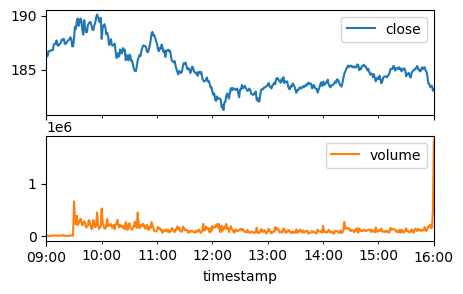

In [33]:
# timestamps = pd.to_datetime(stock_bars_minute_df.pop('timestamp'))

# 2022/06/01 used for following graphs

minute_bars_20220601_df = days_df[days_df['date'] == datetime.date(2022, 6, 1)]['minute_bars'].iloc[0] # access day's minute_bars dataframe for a given date
timestamps_20220601 = pd.to_datetime(minute_bars_20220601_df.pop('timestamp'))

# plot close and volume
plot_cols = ['close', 'volume']

plot_features = minute_bars_20220601_df[plot_cols]
plot_features.index = timestamps_20220601
_ = plot_features.plot(subplots=True)

Text(0.5, 1.0, 'Time of day signal')

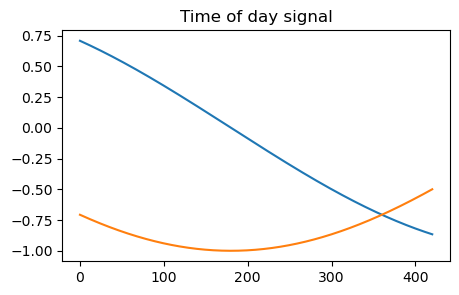

In [34]:
timestamp_s = timestamps_20220601.map(pd.Timestamp.timestamp)

seconds_per_day = 24*60*60
seconds_per_week = seconds_per_day*7
seconds_per_year = seconds_per_week*52.1429

minute_bars_20220601_df['day-sin'] = np.sin(timestamp_s * (2 * np.pi / seconds_per_day))
minute_bars_20220601_df['day-cos'] = np.cos(timestamp_s * (2 * np.pi / seconds_per_day))

minute_bars_20220601_df['week-sin'] = np.sin(timestamp_s * (2 * np.pi / seconds_per_week))
minute_bars_20220601_df['week-cos'] = np.cos(timestamp_s * (2 * np.pi / seconds_per_week))

minute_bars_20220601_df['year-sin'] = np.sin(timestamp_s * (2 * np.pi / seconds_per_year))
minute_bars_20220601_df['year-cos'] = np.cos(timestamp_s * (2 * np.pi / seconds_per_year))

plt.plot(np.array(minute_bars_20220601_df['day-sin']))
plt.plot(np.array(minute_bars_20220601_df['day-cos']))
plt.title('Time of day signal')

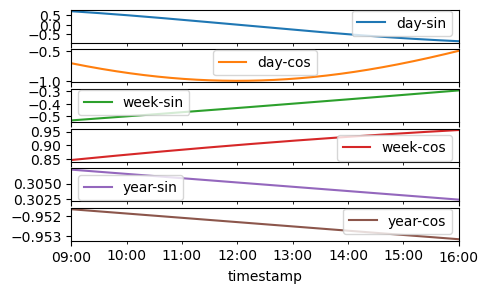

In [35]:
# plot close and volume
plot_cols = ['day-sin', 'day-cos', 'week-sin', 'week-cos','year-sin', 'year-cos']

plot_features = minute_bars_20220601_df[plot_cols]
plot_features.index = timestamps_20220601
_ = plot_features.plot(subplots=True)

In [37]:
# split into training (70%), validation (20%), and test (10%) sets

n = len(days_df)
train_df = days_df[0:int(n*0.7)]
val_df = days_df[int(n*0.7):int(n*0.9)]
test_df = days_df[int(n*0.9):]

num_features = minute_bars_20220601_df.shape[1]
